<a href="https://colab.research.google.com/github/Mohd6288/DAMLCP_Project/blob/main/pix2pix_visualization_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Visualizing PIX2PIX Training

In this notebook, you can use pre-trained models with different datasets to generate new style images using Pix2Pix. You can create a new dataset or make a PDF album out of the images and save it to your drive.

Here are all the pre-trained models and jellyfish images you can use. You can use the command line to download the data and organize it in a notebook structure, making it easier for you to use.



Use this :
```
!gdown 1etVduhl0YdZXfuu14sUXyNH2k0ESO6pv #pix2pix_rembrandt.iter_10879_scripted.pt
!gdown 1SEU37hC-Be-5aJzLSJvRNFC3OPotafmc #pix2pix_face2comics.iter_72000_scripted.pt
!gdown 1UN-Uwl8yQQgVQ-lfRbpvxnQCmfD-QTJg #Jullayfish_images
!unzip /content/allJullyImags.zip -d /content/input_images
!mv input_images/allJullyImags/* input_images/
!rm input_images/allJullyImags/
```

https://drive.google.com/file/d/1UN-Uwl8yQQgVQ-lfRbpvxnQCmfD-QTJg/view?usp=sharing

https://drive.google.com/file/d/1etVduhl0YdZXfuu14sUXyNH2k0ESO6pv/view?usp=sharing


https://drive.google.com/file/d/1SEU37hC-Be-5aJzLSJvRNFC3OPotafmc/view?usp=sharing

https://drive.google.com/drive/folders/1xyN6O3yrJjP9Sh1bfKhdcI6gU-3CnCWH?usp=sharing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install fpdf

  Preparing metadata (setup.py) ... done
  Created wheel for fpdf: filename=fpdf-1.7.2-py2.py3-none-any.whl size=40704 sha256=f2e88c20af50dc394f8da5f6c4ee21f91ae31a0eee8d71e9130fd6e646cc1d5b
  Stored in directory: /root/.cache/pip/wheels/f9/95/ba/f418094659025eb9611f17cbcaf2334236bf39a0c3453ea455
Successfully built fpdf


#Step 1: Install and Import Required Libraries

In [ ]:
import os
import pathlib
import numpy as np

import torch

import torchvision as tv
from torchvision.transforms import v2

import cv2
from skimage import io
from skimage import feature

import matplotlib
import matplotlib.pyplot as plt

from PIL import Image
import shutil
from fpdf import FPDF

# Get cpu, gpu or mps device for training
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


#Define Helper Functions

In [ ]:
from torchvision import transforms

# Define a resample filter that works with different Pillow versions
try:
    resample_filter = Image.Resampling.LANCZOS
except AttributeError:
    resample_filter = Image.LANCZOS  # For older Pillow versions

def generate(model, image):
    """
    Generates an output image using the loaded model.

    Parameters:
    - model (torch.jit.ScriptModule): The loaded PyTorch model.
    - image (numpy.ndarray): Input image as a NumPy array.

    Returns:
    - output (numpy.ndarray): The generated image as a NumPy array.
    """
    # Convert NumPy array to PIL Image
    image = Image.fromarray(image).convert('RGB')

    # Apply necessary transformations
    transform = transforms.Compose([
        transforms.Resize((256, 256), interpolation=resample_filter),  # Changed 'resample' to 'interpolation'
        transforms.ToTensor(),  # Converts to [0,1]
    ])

    image = transform(image).to(device)
    image = image.unsqueeze(0)  # Add batch dimension

    with torch.no_grad():
        output = model(image).cpu()

    # Assuming the model output is in range [-1,1], scale to [0,1]
    output = (output + 1) / 2
    output = output.squeeze(0).permute(1, 2, 0).numpy()
    return output

def apply_bw_cv2(img):
    """Turn an image black and white using OpenCV."""
    grey_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    return cv2.merge([grey_img, grey_img, grey_img])  # Force three channels for shape compatibility

def apply_canny_cv2(img, thresh1=160, thresh2=250, invert=False):
    """Apply the OpenCV Canny edge detector to an image."""
    grey_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(grey_img, thresh1, thresh2)
    if invert:
        edges = cv2.bitwise_not(edges)
    return cv2.cvtColor(edges, cv2.COLOR_GRAY2RGB)

def apply_canny_skimage(img, sigma=1.5, invert=False):
    """Apply the Scikit-Image Canny edge detector to an image."""
    grey_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    edges = (feature.canny(grey_img, sigma=sigma)*255).astype(np.uint8)
    if invert:
        edges = cv2.bitwise_not(edges)
    return cv2.cvtColor(edges, cv2.COLOR_GRAY2RGB)

def load_model(models_dir, chosen_dir_index, chosen_model_index):
    """
    Loads a PyTorch model from the specified directory.

    Parameters:
    - models_dir (Path): Path to the parent directory containing model subdirectories.
    - chosen_dir_index (int): Index of the subdirectory to select.
    - chosen_model_index (int): Index of the model file within the chosen subdirectory.

    Returns:
    - model (torch.jit.ScriptModule): The loaded PyTorch model.
    """
    # Check available directories
    dnames = [d for d in models_dir.iterdir() if d.is_dir()]

    if not dnames:
        print(f"No directories found in {models_dir}")
        return None

    print("Available directories:")
    for i, d in enumerate(dnames):
        print(f"{i} | {d}")
    print()

    # Choose your directory
    if chosen_dir_index < 0 or chosen_dir_index >= len(dnames):
        print(f"!!Directory index ({chosen_dir_index}) invalid!!")
        return None

    chosen_dir = dnames[chosen_dir_index]
    print("Chosen directory:")
    print(f"{chosen_dir_index} | {chosen_dir}")
    print("---")

    # Check available models
    fnames = list(chosen_dir.glob("*.pt"))

    if not fnames:
        print(f"No model files found in {chosen_dir}")
        return None

    print("Available models:")
    for i, f in enumerate(fnames):
        print(f"{i} | {f.name}")
    print()

    # Choose your model
    if chosen_model_index < 0 or chosen_model_index >= len(fnames):
        print(f"!!Model index ({chosen_model_index}) invalid!!")
        return None

    chosen_model_file = fnames[chosen_model_index]
    print("Chosen model:")
    print(f"{chosen_model_index} | {chosen_model_file.name}")
    print("---")

    # Load the model
    try:
        model = torch.jit.load(chosen_model_file, map_location=device)
        print("Model loaded successfully.")
        return model
    except Exception as e:
        print(f"Error loading model: {e}")
        return None

def display_transform(model, img_path, transform=None):
    """
    Displays the input, processed, and generated images side by side.

    Parameters:
    - model (torch.jit.ScriptModule): The loaded PyTorch model.
    - img_path (str or Path): Path to the input image.
    - transform (function, optional): Optional transformation function to apply to the image.

    Returns:
    - img (numpy.ndarray): The generated image as a NumPy array.
    """
    # Read the image using skimage
    img = io.imread(img_path)

    plt.figure(figsize=(18,6))

    # Display Input Image
    plt.subplot(1, 3, 1)
    plt.title('Input Image')
    plt.imshow(img)
    plt.axis('off')

    # Apply Transformation if provided
    if transform:
        processed_img = transform(img)
        plt.subplot(1, 3, 2)
        plt.title('Processed Image')
        plt.imshow(processed_img)
        plt.axis('off')
    else:
        processed_img = img  # No transformation applied
        plt.subplot(1, 3, 2)
        plt.title('Processed Image (No Transformation)')
        plt.imshow(processed_img)
        plt.axis('off')

    # Generate Output Image
    output_img = generate(model, processed_img)
    plt.subplot(1, 3, 3)
    plt.title('Generated Image')
    plt.imshow(output_img)
    plt.axis('off')

    plt.show()

    return output_img

 #Upload Your Image

In [ ]:
from google.colab import files
from pathlib import Path  # Add this line to import Path
# Define input and output directories
input_images_dir = Path("/content/input_images")
output_images_dir = Path("/content/output_images")

# Create input and output directories
input_images_dir.mkdir(parents=True, exist_ok=True)
output_images_dir.mkdir(parents=True, exist_ok=True)


In [ ]:
# !gdown 1etVduhl0YdZXfuu14sUXyNH2k0ESO6pv #pix2pix_rembrandt.iter_10879_scripted.pt
# !gdown 1SEU37hC-Be-5aJzLSJvRNFC3OPotafmc #pix2pix_face2comics.iter_72000_scripted.pt
# !gdown 1UN-Uwl8yQQgVQ-lfRbpvxnQCmfD-QTJg #Jullayfish_images
# !unzip /content/allJullyImags.zip -d /content/input_images
# !mv input_images/allJullyImags/* input_images/

Downloading...
From (original): https://drive.google.com/uc?id=1etVduhl0YdZXfuu14sUXyNH2k0ESO6pv
From (redirected): https://drive.google.com/uc?id=1etVduhl0YdZXfuu14sUXyNH2k0ESO6pv&confirm=t&uuid=36257c69-69f1-49f2-b50f-e232e3810ad9
To: /content/pix2pix_rembrandt.iter_10879_scripted.pt
100% 218M/218M [00:03<00:00, 69.2MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1SEU37hC-Be-5aJzLSJvRNFC3OPotafmc
From (redirected): https://drive.google.com/uc?id=1SEU37hC-Be-5aJzLSJvRNFC3OPotafmc&confirm=t&uuid=4f5eaac2-c5b9-4650-b2ed-aaa1a567dd7d
To: /content/pix2pix_face2comics.iter_72000_scripted.pt
100% 218M/218M [00:02<00:00, 73.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1UN-Uwl8yQQgVQ-lfRbpvxnQCmfD-QTJg
To: /content/allJullyImags.zip
100% 10.9M/10.9M [00:00<00:00, 40.3MB/s]
Archive:  /content/allJullyImags.zip
  inflating: /content/input_images/allJullyImags/01.jpeg  
  inflating: /content/input_images/allJullyImags/01_c_1 (1).jpeg  
  inflating: /content/inp

Upload multiple images

```
uploaded = files.upload()

# Move uploaded images to 'input_images' directory
for filename in uploaded.keys():
    shutil.move(filename, input_images_dir / filename)

print(f"Uploaded and moved images to {input_images_dir}")
```



##Load the Model

Instructions:

Run the cell above.
The load_model function will print available directories and models.
Adjust chosen_dir_index and chosen_model_index:
Based on the printed list, set these indices to select the desired model.
Example: If there's only one directory and one model, both indices should be 0.

In [ ]:
# Define the path to your models directory
# URL https://drive.google.com/drive/folders/1xyN6O3yrJjP9Sh1bfKhdcI6gU-3CnCWH?usp=sharing
models_dir = Path("/content/drive/MyDrive/models/new_one")  # Update with your actual path

# Load the model (choose appropriate directory and model indices)
chosen_dir_index = 3  # Adjust based on available directories
chosen_model_index = 0  # Adjust based on available models within the chosen directory

model = load_model(models_dir, chosen_dir_index, chosen_model_index)

if model:
    print("Model is ready for inference.")
else:
    print("Model loading failed.")

Available directories:
0 | /content/drive/MyDrive/models/new_one/pix2pix_face2comics
1 | /content/drive/MyDrive/models/new_one/pix2pix_face2comics2
2 | /content/drive/MyDrive/models/new_one/code
3 | /content/drive/MyDrive/models/new_one/pix2pix_rembrandt
4 | /content/drive/MyDrive/models/new_one/pix2pix_cityscapes
5 | /content/drive/MyDrive/models/new_one/pix2pix_edge2comics
6 | /content/drive/MyDrive/models/new_one/pix2pix_maps

Chosen directory:
3 | /content/drive/MyDrive/models/new_one/pix2pix_rembrandt
---
Available models:
0 | pix2pix_rembrandt.iter_5439.pt
1 | pix2pix_rembrandt.iter_10879_scripted.pt
2 | landmarks2rembrandt_195_generator.pt

Chosen model:
0 | pix2pix_rembrandt.iter_5439.pt
---
Model loaded successfully.
Model is ready for inference.


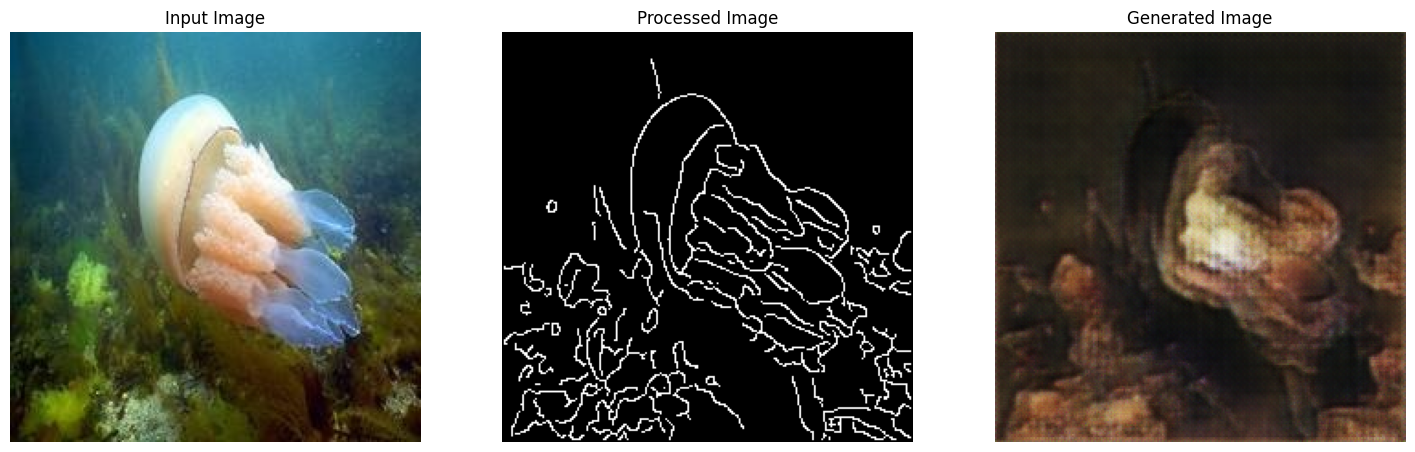

In [ ]:
#  Correct function call
generated_img = display_transform(model,"/content/input_images/01.jpeg", transform=apply_canny_skimage)

In [ ]:
def process_and_save_images(
    model,
    input_dir,
    output_dir,
    transform=apply_canny_skimage,
    target_resolution=(256, 256),
    padding_color=(0, 0,0)
):
    """
    Processes multiple images: prepares for iPhone, applies transformations,
    generates output images using the model, and saves them.

    Parameters:
    - model (torch.jit.ScriptModule): The loaded PyTorch model.
    - input_dir (Path): Directory containing input images.
    - output_dir (Path): Directory to save generated images.
    - transform (function, optional): Optional transformation function to apply to the image.
    - target_resolution (tuple): Target resolution for resizing.
    - padding_color (tuple): RGB color for padding if aspect ratio is preserved.
    """
    # Create output directory if it doesn't exist
    output_dir.mkdir(parents=True, exist_ok=True)

    # List of image files (assuming common image extensions)
    image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff']
    image_files = [f for f in input_dir.iterdir() if f.suffix.lower() in image_extensions]

    if not image_files:
        print(f"No images found in {input_dir}")
        return

    for img_file in image_files:
        print(f"Processing {img_file.name}...")

        # Read image
        img = io.imread(img_file)

        # Apply transformation if provided
        if transform:
            processed_img = transform(img)
        else:
            processed_img = img  # No transformation

        # Generate output image
        output_img = generate(model, processed_img)

        # Convert to PIL Image and save
        output_pil = Image.fromarray((output_img * 255).astype(np.uint8))
        output_filename = output_dir / f"generated_{img_file.name}"
        output_pil.save(output_filename)
        print(f"Saved generated image as {output_filename.name}")

    print(f"All images have been processed and saved to {output_dir}")


In [ ]:
# Process and save all images in the input directory
process_and_save_images(
    model=model,
    input_dir=input_images_dir,
    output_dir=output_images_dir,
    transform=apply_canny_skimage,  # Set to None if you don't want to apply transformation
    target_resolution=(256, 256),  # Adjust as needed
    padding_color=(0, 0,0)  # White padding
)


In [ ]:
def create_pdf_album(image_dir, album_path):
    """
    Creates a PDF album from generated images.

    Parameters:
    - image_dir (Path): Directory containing generated images.
    - album_path (Path): Path to save the PDF album.

    Returns:
    - None
    """
    image_files = sorted([f for f in image_dir.iterdir() if f.suffix.lower() in ['.jpg', '.jpeg', '.png', '.bmp', '.tiff']])
    if not image_files:
        print(f"No images found in {image_dir} to create a PDF album.")
        return

    pdf = FPDF()
    for img_file in image_files:
        cover = Image.open(img_file)
        width, height = cover.size

        # Convert pixels to mm with 1px=0.264583 mm
        width, height = width * 0.264583, height * 0.264583

        # A4 size is 210 x 297 mm
        pdf_w, pdf_h = 210, 297
        ratio = min(pdf_w/width, pdf_h/height)
        width, height = width * ratio, height * ratio

        pdf.add_page()
        pdf.image(str(img_file), x=(pdf_w - width) / 2, y=(pdf_h - height) / 2, w=width, h=height)

    pdf.output(str(album_path))
    print(f"PDF album created at {album_path}")


In [ ]:
# Define the path to save the PDF album
album_path = Path("/content/generated_photo_album.pdf")  # Update as desired

# Create the PDF album
create_pdf_album(
    image_dir=output_images_dir,
    album_path=album_path
)

# Download the PDF album
files.download(str(album_path))


PDF album created at /content/generated_photo_album.pdf


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# !cp /content/output_images/* /content/drive/MyDrive/datasets/JullyFish_generated_images

In [ ]:
# Install or update ffmpeg
# !apt-get update
# !apt-get install ffmpeg

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:8 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [2,517 kB]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:11 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [3,448 kB]
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:13 http://security.ubuntu.com/ubuntu jammy-security/univer

In [ ]:

output_images_dir = Path("/content/output_images")

# List all image files
image_files = sorted(output_images_dir.glob("*.*"))  # Adjust the pattern if necessary

for img_path in image_files:
    try:
        with Image.open(img_path) as img:
            # Define new image path with .png extension
            new_name = img_path.stem + ".png"
            new_path = img_path.with_name(new_name)

            # Save image in PNG format
            img.save(new_path, format='PNG')
            print(f"Saved {img_path.name} as {new_path.name}")

            # Optionally, remove the old file
            img_path.unlink()
    except Exception as e:
        print(f"{img_path.name}: Error - {e}")


In [ ]:
# Define parameters
input_pattern = "image%03d.png"  # Adjust based on your image naming (e.g., image001.png)
output_video = "output_video.mp4"
fps = 24  # Frames per second

# Change directory to output_images_dir
%cd /content/output_images

# Generate the video
!ffmpeg -framerate {fps} -i {input_pattern} -c:v libx264 -pix_fmt yuv420p /content/{output_video}


/content/output_images
ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis